In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from pyDOE import lhs   # Latin Hypercube Sampling

## Damped Harmonic Oscillator

$$m\frac{d^2 u}{dt^2} + \mu\frac{du}{dt} + ku = 0,\quad u(0) = 1,\quad \frac{du}{dt}(0) = 0,\quad t\in[0, 1]$$

### Modeling

In [ ]:
def u_exact(t, d=2, w0=20):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A * np.cos(phi + w*t) * np.exp(-d*t)

# dy/dx using autograd
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

# u_tt + mu*u_t + k*u = 0
def loss_pde(model, t, mu, k):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    u_tt = gradient(u_t, t)
    return torch.mean((u_tt + mu*u_t + k*u)**2)

# u_t(0) = 0
def loss_ic1(model, t, du_ic):
    t.requires_grad = True
    u = model(t)
    du = gradient(u, t)
    return torch.mean((du - du_ic)**2)

# u(0) = 1
def loss_ic2(model, t, u_ic):
    u = model(t)
    return torch.mean((u - u_ic)**2)

### Training

In [ ]:
# Hyperparameters
d, w0 = 2, 20
mu, k = 2*d, w0**2      # u_tt + mu*u_t + k*u = 0
n_points = 101
learning_rate = 1e-3
n_epochs = 20000

# Collocation points: t in (0, 1)
torch.manual_seed(0)
t = lhs(1, samples=n_points)    # Latin Hypercube Sampling
t = torch.tensor(t).float().view(-1, 1)

# Initial Conditions: u(0) = 1, u'(0) = 0
t_ic = torch.tensor(0).float().view(-1, 1)
u_ic = torch.tensor(1).float().view(-1, 1)
du_ic = torch.tensor(0).float().view(-1, 1)

model = nn.Sequential(
            nn.Linear(1, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1),
        )
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

losses = {}
for epoch in range(1, n_epochs + 1):
    losses["pde"] = loss_pde(model, t, mu, k)
    losses["ic1"] = loss_ic1(model, t_ic, du_ic)
    losses["ic2"] = loss_ic2(model, t_ic, u_ic)
    loss = 1e-4 * losses["pde"] + 1e-2 * losses["ic1"] + losses["ic2"]

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] "
              f"losses: {loss.item():.3e} (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"pde: {losses['pde'].item():.3e} "
              f"ic1: {losses['ic1'].item():.3e} "
              f"ic2: {losses['ic2'].item():.3e}")

[ 2000/20000] losses: 1.010e-02 (lr: 9.02e-04) pde: 9.866e+01 ic1: 4.182e-08 ic2: 2.295e-04
[ 4000/20000] losses: 8.763e-03 (lr: 8.15e-04) pde: 8.662e+01 ic1: 3.551e-05 ic2: 1.008e-04
[ 6000/20000] losses: 7.385e-03 (lr: 7.35e-04) pde: 7.301e+01 ic1: 4.232e-06 ic2: 8.401e-05
[ 8000/20000] losses: 2.861e-03 (lr: 6.63e-04) pde: 2.827e+01 ic1: 3.041e-07 ic2: 3.327e-05
[10000/20000] losses: 1.369e-03 (lr: 5.99e-04) pde: 1.359e+01 ic1: 7.367e-07 ic2: 1.002e-05
[12000/20000] losses: 4.243e-04 (lr: 5.40e-04) pde: 4.219e+00 ic1: 3.114e-08 ic2: 2.442e-06
[14000/20000] losses: 1.516e-04 (lr: 4.88e-04) pde: 1.512e+00 ic1: 2.355e-08 ic2: 4.252e-07
[16000/20000] losses: 1.003e-04 (lr: 4.40e-04) pde: 1.001e+00 ic1: 1.726e-09 ic2: 1.861e-07
[18000/20000] losses: 9.124e-05 (lr: 3.97e-04) pde: 8.903e-01 ic1: 1.671e-04 ic2: 5.464e-07
[20000/20000] losses: 1.611e-04 (lr: 3.58e-04) pde: 1.590e+00 ic1: 2.008e-04 ic2: 1.014e-07


### Evaluation

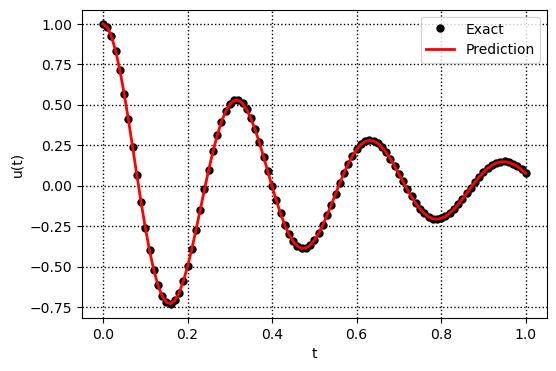

In [16]:
t_test = np.linspace(0, 1, 101)
with torch.no_grad():
    t = torch.tensor(t_test).float().view(-1, 1)
    u_pred = model(t).numpy()

# Plotting the results
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t_test, u_exact(t_test, d, w0), 'ko', label="Exact", ms=5)
ax.plot(t_test, u_pred, 'r', lw=2, label="Prediction")
ax.set(xlabel="t", ylabel="u(t)")
ax.grid(color="k", ls=":", lw=1)
ax.legend()
plt.show()